In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [3]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)


Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
36384  00009604_006.png           Mass            6        9604           46   
64455  00015911_000.png     No Finding            0       15911           60   
77602  00019083_000.png     No Finding            0       19083           47   

      Patient Gender View Position  OriginalImage[Width  Height]  \
36384              M            PA                 2500     2048   
64455              M            PA                 2500     2048   
77602              F            AP                 2500     2048   

       OriginalImagePixelSpacing[x     y]  Unnamed: 11  
36384                        0.168  0.168          NaN  
64455                        0.168  0.168          NaN  
77602                        0.168  0.168          NaN

In [4]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

Image Index Finding Labels  Follow-up #  Patient ID Patient Age  \
1202  00006338_003.png         Nodule            3        6338        053Y   
4011  00019772_001.png     No Finding            1       19772        073Y   
1614  00008397_003.png  Consolidation            3        8397        053Y   

     Patient Gender View Position  OriginalImageWidth  OriginalImageHeight  \
1202              F            AP                2500                 2048   
4011              M            AP                2500                 2048   
1614              M            AP                2500                 2048   

      OriginalImagePixelSpacing_x  OriginalImagePixelSpacing_y  
1202                        0.171                        0.171  
4011                        0.168                        0.168  
1614                        0.168                        0.168

### EDA

In [6]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


In [7]:
all_xray_df = all_xray_df.drop(columns=['Unnamed: 11'])

In [9]:
all_xray_df['Finding Labels'].str.split('|', expand=True).stack().unique()

array(['Cardiomegaly', 'Emphysema', 'Effusion', 'No Finding', 'Hernia',
       'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax',
       'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema',
       'Consolidation'], dtype=object)

In [10]:
all_xray_df['Finding Labels'].str.split('|', expand=True).stack().value_counts()

No Finding            60361
Infiltration          19894
Effusion              13317
Atelectasis           11559
Nodule                 6331
Mass                   5782
Pneumothorax           5302
Consolidation          4667
Pleural_Thickening     3385
Cardiomegaly           2776
Emphysema              2516
Edema                  2303
Fibrosis               1686
Pneumonia              1431
Hernia                  227
dtype: int64

In [11]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))

from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


Image Index             Finding Labels  Follow-up #  Patient ID  \
111123  00030323_050.png                                      50       30323   
38766   00010120_022.png                  Emphysema           22       10120   
93120   00023271_012.png  Edema|Infiltration|Nodule           12       23271   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
111123           32              F            AP                 3056   
38766            52              M            PA                 2992   
93120            40              F            AP                 3056   

        Height]  OriginalImagePixelSpacing[x  ...  Effusion  Emphysema  \
111123     2544                        0.139  ...       0.0        0.0   
38766      2991                        0.143  ...       0.0        1.0   
93120      2544                        0.139  ...       0.0        0.0   

        Fibrosis  Hernia  Infiltration  Mass  Nodule  Pleural_Thickening  \
111123       0.0     0.0           0.0   0.0     0.0                 0.0   
38766        0.0     0.0           0.0   0.0     0.0                 0.0   
93120        0.0     0.0           1.0   0.0     1.0                 0.0   

        Pneumonia  Pneumothorax  
111123        0.0           0.0  
38766         0.0           0.0  
93120         0.0           0.0  

[3 rows x 25 columns]

In [12]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 25 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Atelectasis                  112120 non-null  float64
 12  Cardiomegaly                 112120 non-null  float64
 13 

### The patient demographic

In [17]:
# Drop rows with ages above 120
all_xray_df = all_xray_df[all_xray_df['Patient Age'] <= 120]

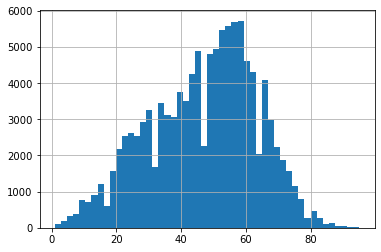

In [18]:
all_xray_df['Patient Age'].hist(bins=50)

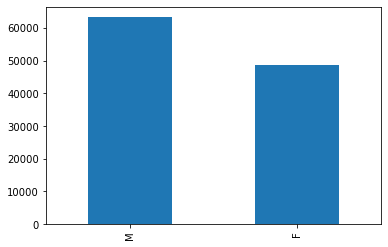

In [20]:
# Patient gender distribution
all_xray_df['Patient Gender'].value_counts().plot(kind='bar')

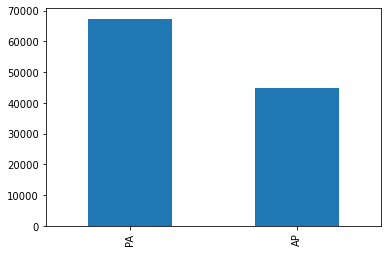

In [22]:
# Patient view position distribution
all_xray_df['View Position'].value_counts().plot(kind='bar')

### Pneumonia cases distribution

In [24]:
pneumonia_counts = all_xray_df['Pneumonia'].value_counts()
pneumonia_percentage = pneumonia_counts / len(all_xray_df) * 100
pneumonia_percentage

0.0    98.724399
1.0     1.275601
Name: Pneumonia, dtype: float64

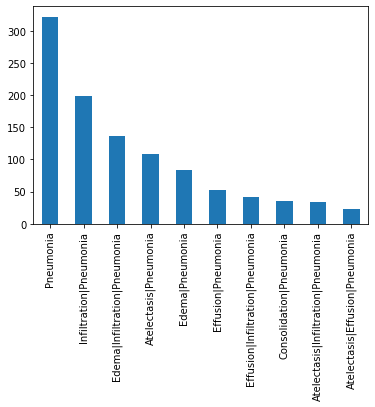

In [25]:
# the distribution of pneumonia cases co-occurrence with other diseases
pneumonia_cooccur = all_xray_df[all_xray_df['Pneumonia']==1]['Finding Labels'].value_counts()
pneumonia_cooccur.head(10).plot(kind='bar')

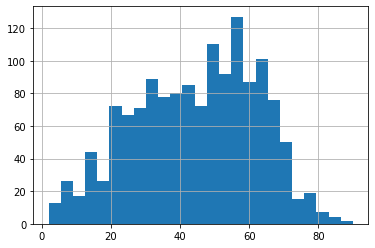

In [27]:
# the distribution of pneumonia cases with respect to patient age
all_xray_df[all_xray_df['Pneumonia']==1]['Patient Age'].hist(bins=25)

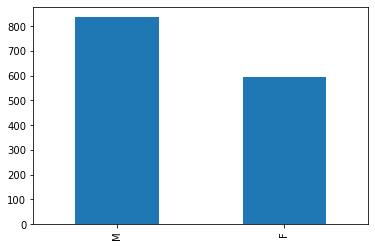

In [28]:
# the distribution of pneumonia cases with respect to patient gender
all_xray_df[all_xray_df['Pneumonia']==1]['Patient Gender'].value_counts().plot(kind='bar')

### Pixel-level assessments of the imaging data

In [5]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  5606 non-null   object 
 1   Finding Labels               5606 non-null   object 
 2   Follow-up #                  5606 non-null   int64  
 3   Patient ID                   5606 non-null   int64  
 4   Patient Age                  5606 non-null   object 
 5   Patient Gender               5606 non-null   object 
 6   View Position                5606 non-null   object 
 7   OriginalImageWidth           5606 non-null   int64  
 8   OriginalImageHeight          5606 non-null   int64  
 9   OriginalImagePixelSpacing_x  5606 non-null   float64
 10  OriginalImagePixelSpacing_y  5606 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 481.9+ KB


In [6]:
sample_df['Finding Labels'] = sample_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))

from itertools import chain
all_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
        
sample_df.sample(3)


All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


Image Index Finding Labels  Follow-up #  Patient ID Patient Age  \
5301  00028539_000.png   Infiltration            0       28539        059Y   
5037  00026774_000.png                           0       26774        067Y   
3055  00015045_018.png  Consolidation           18       15045        029Y   

     Patient Gender View Position  OriginalImageWidth  OriginalImageHeight  \
5301              M            PA                2021                 2021   
5037              M            PA                2021                 2021   
3055              F            AP                2500                 2048   

      OriginalImagePixelSpacing_x  ...  Effusion  Emphysema  Fibrosis  Hernia  \
5301                     0.194311  ...       0.0        0.0       0.0     0.0   
5037                     0.194311  ...       0.0        0.0       0.0     0.0   
3055                     0.168000  ...       0.0        0.0       0.0     0.0   

      Infiltration  Mass  Nodule  Pleural_Thickening  Pneumonia  Pneumothorax  
5301           1.0   0.0     0.0                 0.0        0.0           0.0  
5037           0.0   0.0     0.0                 0.0        0.0           0.0  
3055           0.0   0.0     0.0                 0.0        0.0           0.0  

[3 rows x 25 columns]

In [19]:
# explore image path
image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data', 'images*', '*', '*.png'))}

sample_df['path'] = sample_df['Image Index'].map(image_paths.get)
sample_df.head()

Image Index                                     Finding Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1  00000013_026.png                             Cardiomegaly|Emphysema   
2  00000017_001.png                                                      
3  00000030_001.png                                        Atelectasis   
4  00000032_001.png                        Cardiomegaly|Edema|Effusion   

   Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0            5          13        060Y              M            AP   
1           26          13        057Y              M            AP   
2            1          17        077Y              M            AP   
3            1          30        079Y              M            PA   
4            1          32        055Y              F            AP   

   OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  ...  \
0                3056                 2544                        0.139  ...   
1                2500                 2048                        0.168  ...   
2                2500                 2048                        0.168  ...   
3                2992                 2991                        0.143  ...   
4                2500                 2048                        0.168  ...   

   Emphysema  Fibrosis  Hernia  Infiltration  Mass  Nodule  \
0        1.0       0.0     0.0           1.0   0.0     0.0   
1        1.0       0.0     0.0           0.0   0.0     0.0   
2        0.0       0.0     0.0           0.0   0.0     0.0   
3        0.0       0.0     0.0           0.0   0.0     0.0   
4        0.0       0.0     0.0           0.0   0.0     0.0   

   Pleural_Thickening  Pneumonia  Pneumothorax  \
0                 1.0        0.0           1.0   
1                 0.0        0.0           0.0   
2                 0.0        0.0           0.0   
3                 0.0        0.0           0.0   
4                 0.0        0.0           0.0   

                                       path  
0  /data/images_001/images/00000013_005.png  
1  /data/images_001/images/00000013_026.png  
2  /data/images_001/images/00000017_001.png  
3  /data/images_001/images/00000030_001.png  
4  /data/images_001/images/00000032_001.png  

[5 rows x 26 columns]

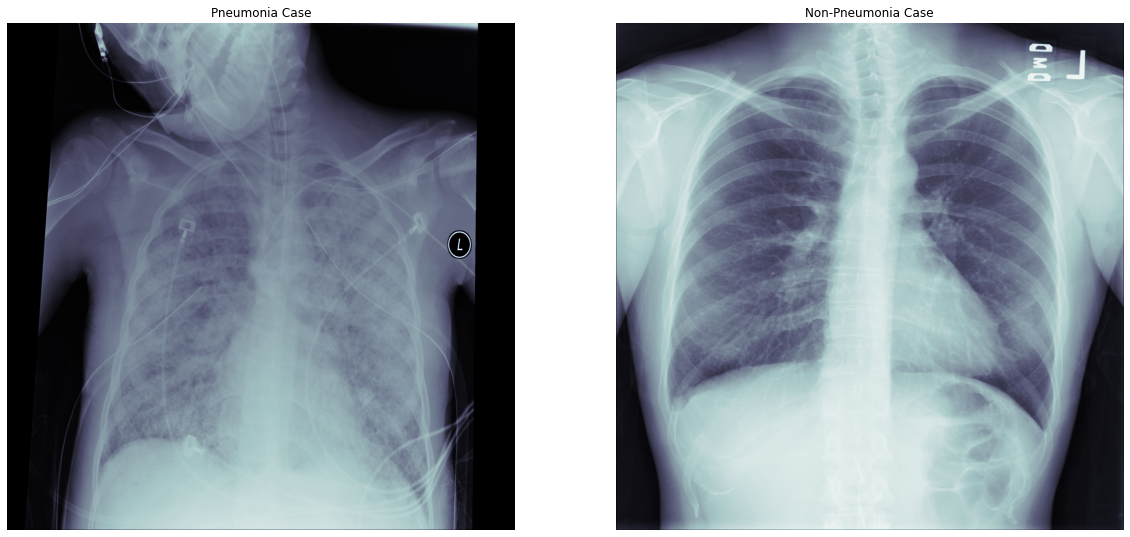

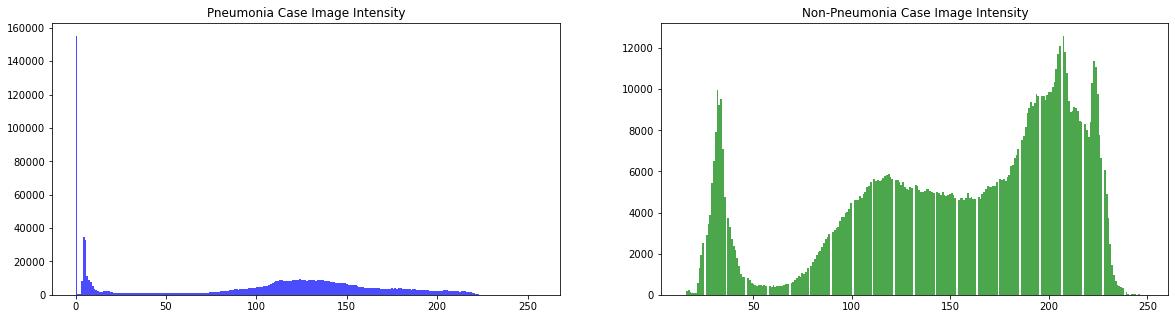

In [22]:
from PIL import Image

# display one image of the Pneumonia cases and one non-case
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, m_axs = plt.subplots(1, 2, figsize=(20, 10))

# Sample one Pneumonia case
pneumonia_case = sample_df[sample_df['Pneumonia'] == 1].sample(1)
pneumonia_img_path = pneumonia_case['path'].values[0]
pneumonia_img_data = Image.open(pneumonia_img_path)
m_axs[0].imshow(pneumonia_img_data, cmap='bone')
m_axs[0].axis('off')
m_axs[0].set_title('Pneumonia Case')

# Sample one non-Pneumonia case
non_pneumonia_case = sample_df[sample_df['Pneumonia'] == 0].sample(1)
non_pneumonia_img_path = non_pneumonia_case['path'].values[0]
non_pneumonia_img_data = Image.open(non_pneumonia_img_path)
m_axs[1].imshow(non_pneumonia_img_data, cmap='bone')
m_axs[1].axis('off')
m_axs[1].set_title('Non-Pneumonia Case')

plt.show()

# Display histogram of image intensity for Pneumonia case
fig, m_axs = plt.subplots(1, 2, figsize=(20, 5))

m_axs[0].hist(np.array(pneumonia_img_data).flat, bins=256, color='blue', alpha=0.7)
m_axs[0].set_title('Pneumonia Case Image Intensity')

# Display histogram of image intensity for Non-Pneumonia case
m_axs[1].hist(np.array(non_pneumonia_img_data).flat, bins=256, color='green', alpha=0.7)
m_axs[1].set_title('Non-Pneumonia Case Image Intensity')

plt.show()

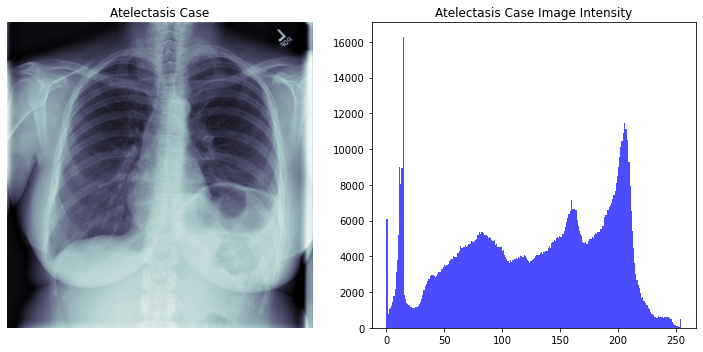

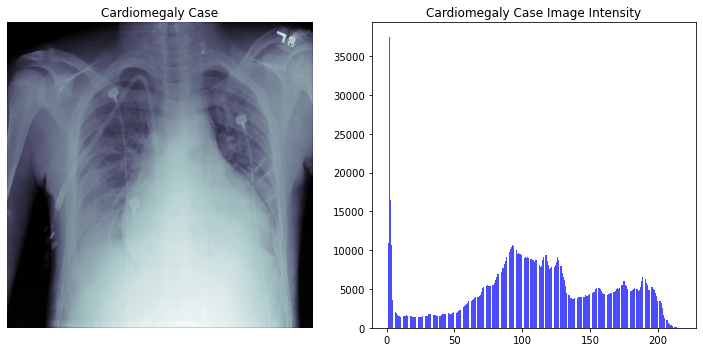

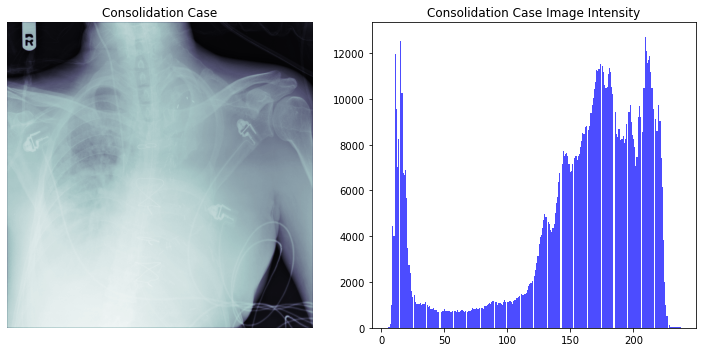

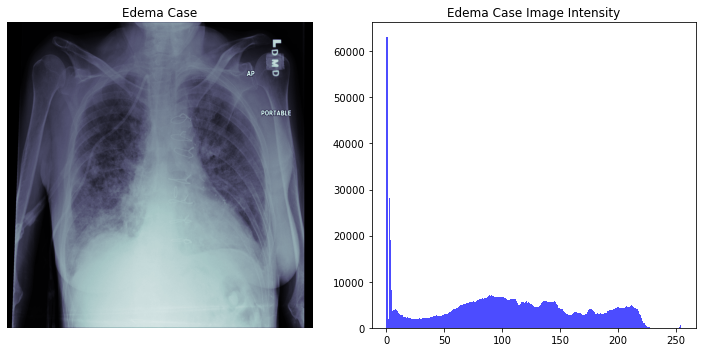

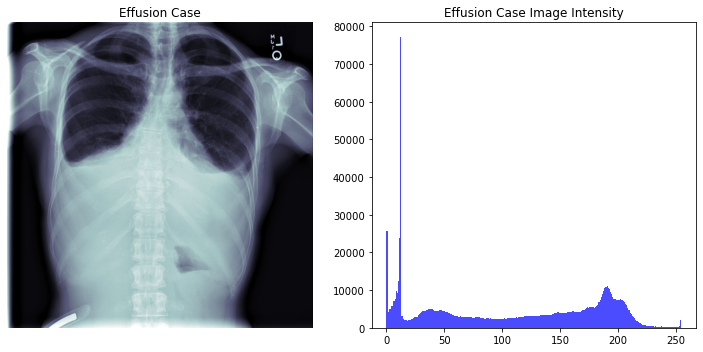

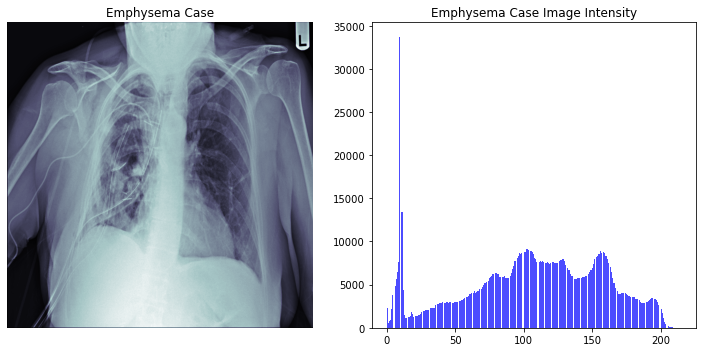

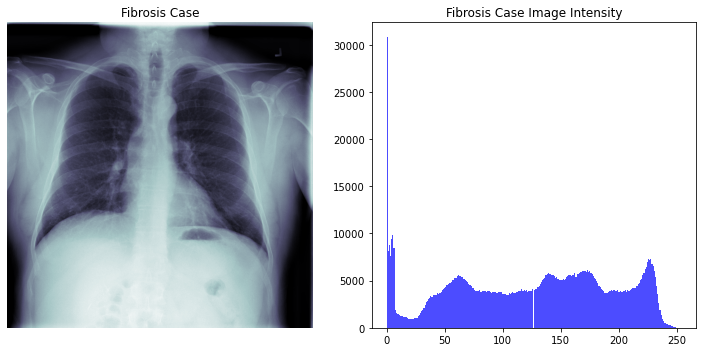

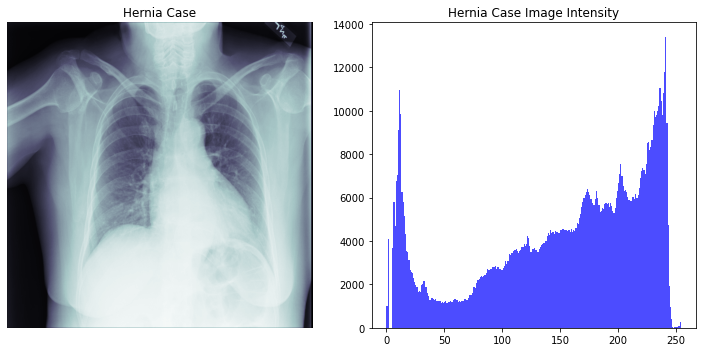

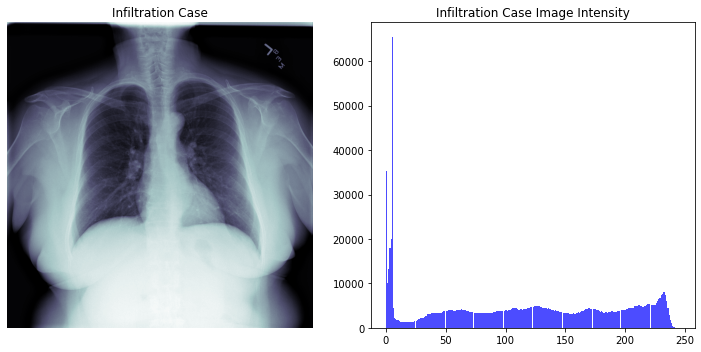

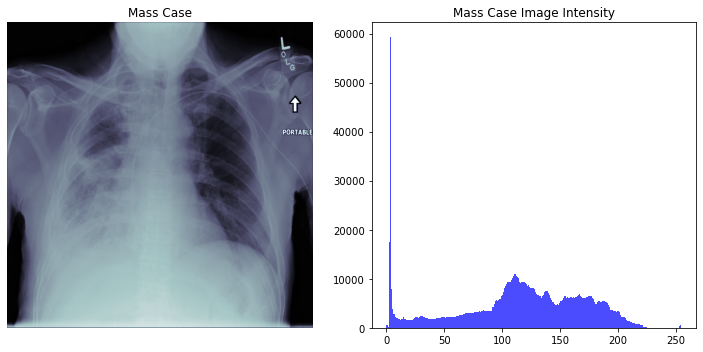

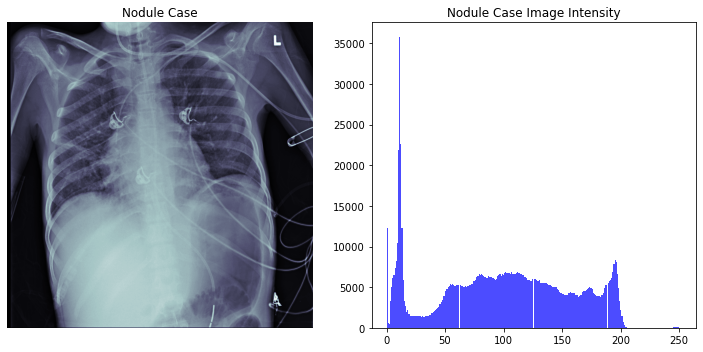

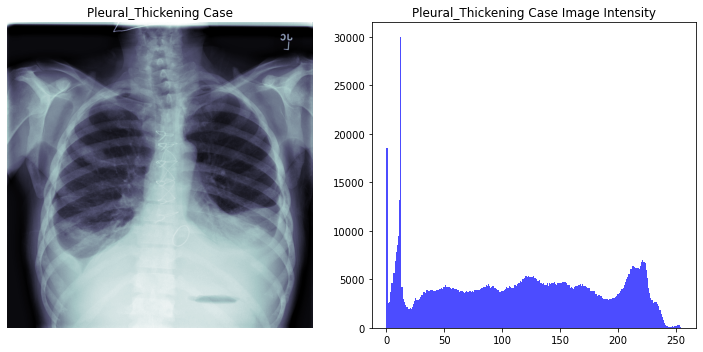

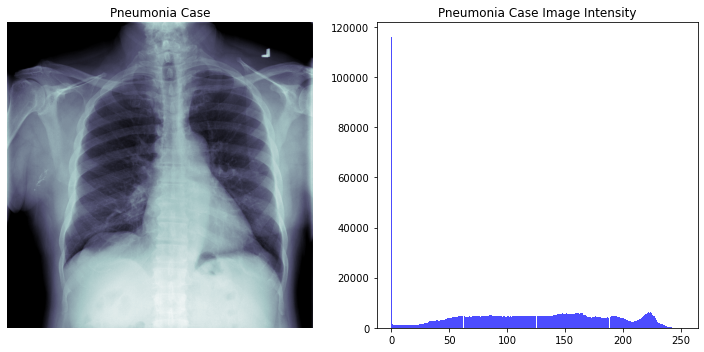

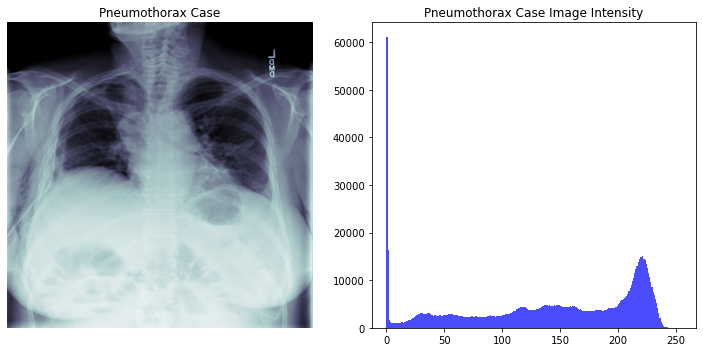

In [27]:
# disease cases
for (idx, c_label) in enumerate(all_labels):
    # Create two subplots in a single row
    fig, m_axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

    # Fetch and load the image
    sample_case = sample_df[sample_df[c_label] == 1].sample(1)
    sample_img_path = sample_case['path'].values[0]
    sample_img_data = Image.open(sample_img_path)
    
    # Display the image
    m_axs[0].imshow(sample_img_data, cmap='bone')
    m_axs[0].axis('off')
    m_axs[0].set_title('{} Case'.format(c_label))
    
    # Display the image intensity histogram
    m_axs[1].hist(np.array(sample_img_data).flat, bins=256, color='blue', alpha=0.7)
    m_axs[1].set_title('{} Case Image Intensity'.format(c_label))

    # Show the row of plots
    plt.tight_layout()
    plt.show()


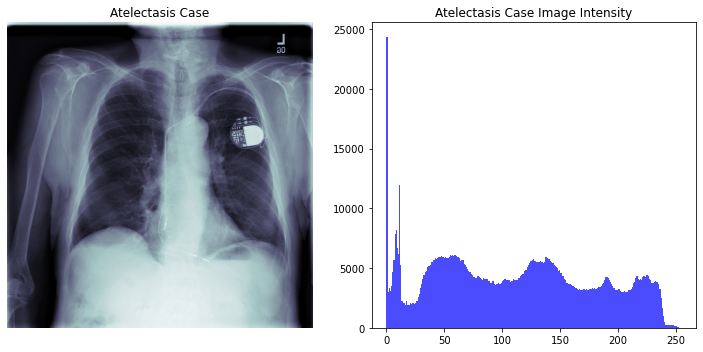

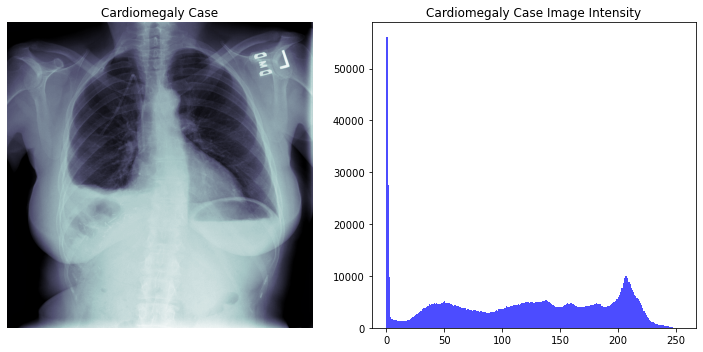

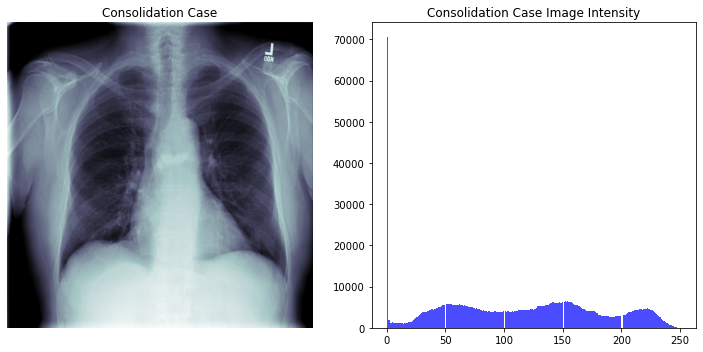

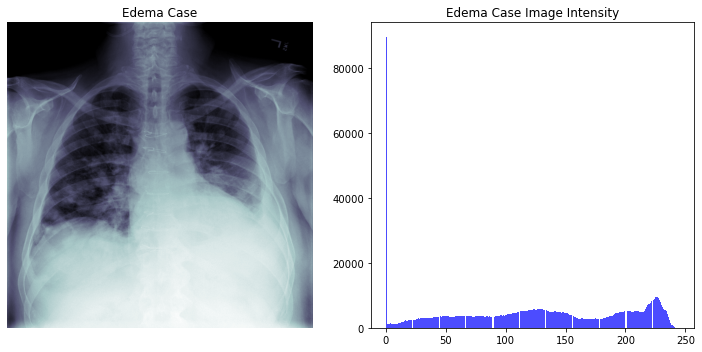

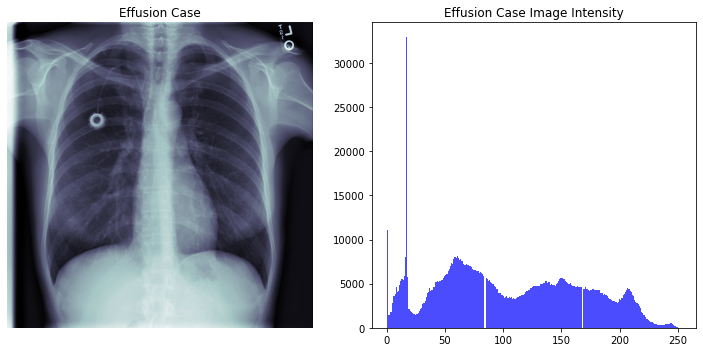

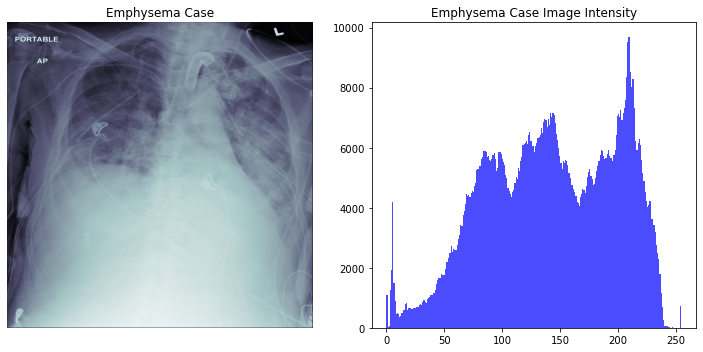

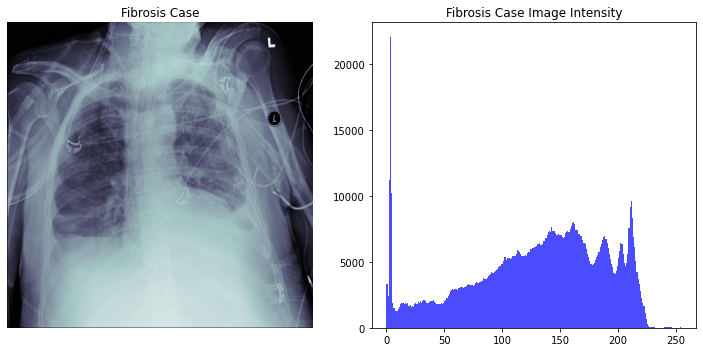

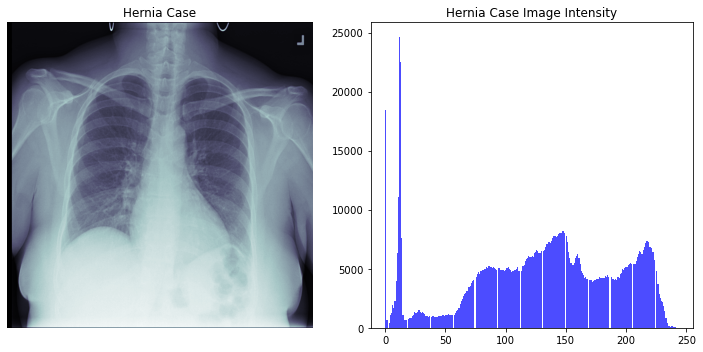

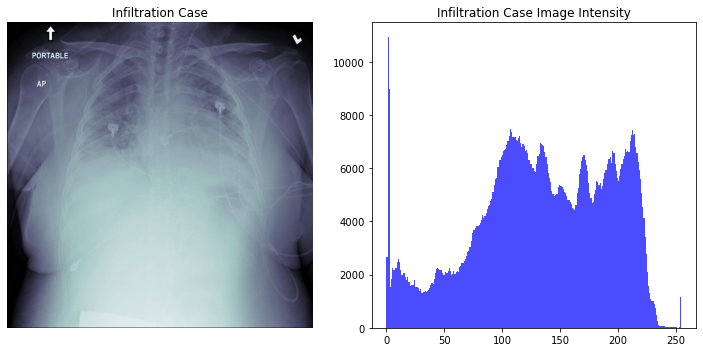

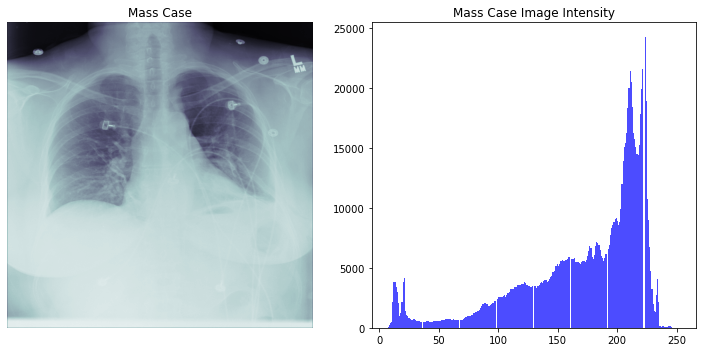

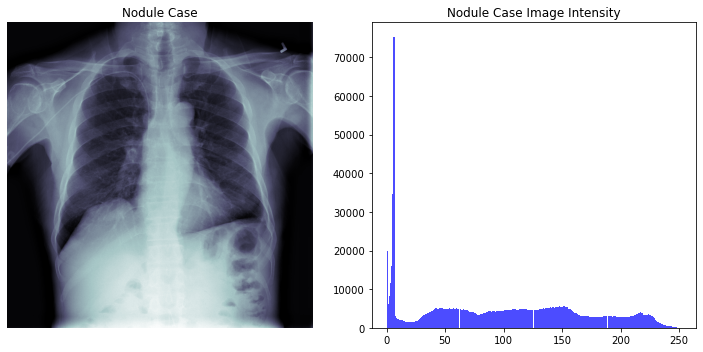

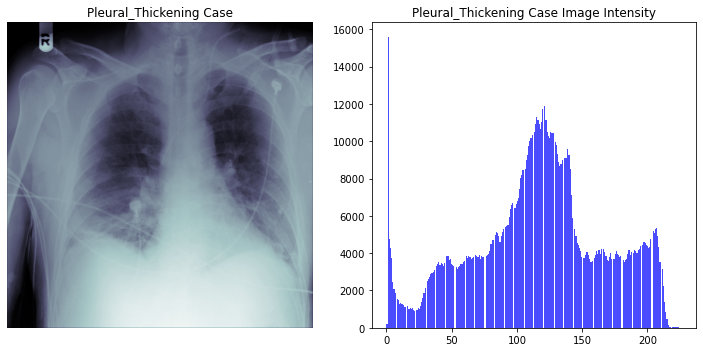

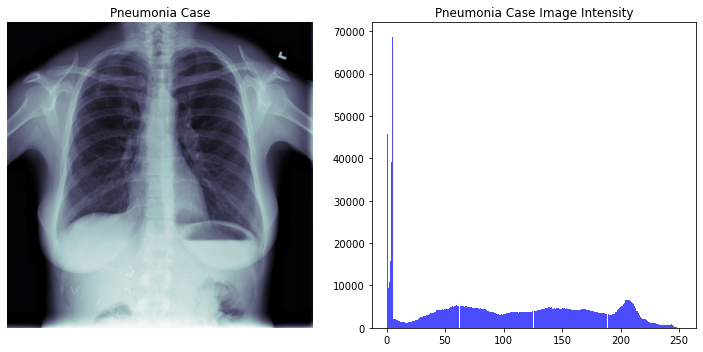

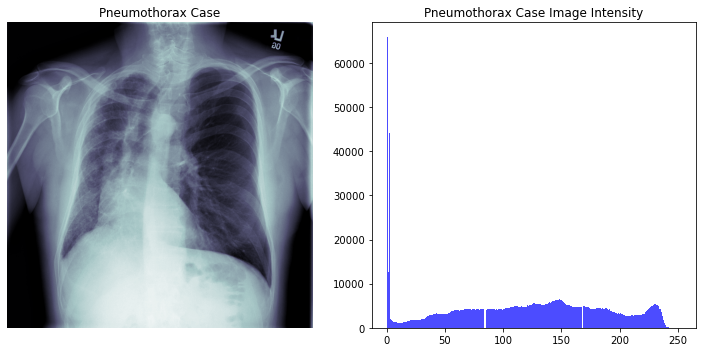

In [28]:
# healthy cases
for (idx, c_label) in enumerate(all_labels):
    # Create two subplots in a single row
    fig, m_axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

    # Fetch and load the image
    sample_case = sample_df[sample_df[c_label] == 0].sample(1)
    sample_img_path = sample_case['path'].values[0]
    sample_img_data = Image.open(sample_img_path)
    
    # Display the image
    m_axs[0].imshow(sample_img_data, cmap='bone')
    m_axs[0].axis('off')
    m_axs[0].set_title('{} Case'.format(c_label))
    
    # Display the image intensity histogram
    m_axs[1].hist(np.array(sample_img_data).flat, bins=256, color='blue', alpha=0.7)
    m_axs[1].set_title('{} Case Image Intensity'.format(c_label))

    # Show the row of plots
    plt.tight_layout()
    plt.show()